In [1]:
data = open('jena_climate_2009_2016.csv', 'r').read()
lines = data.split('\n')
header = lines[0].split(',')
header = header[0:]
lines = lines[1:]
print(header)
print(lines[0])
print(len(data))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
43153572


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

print(float_data.shape)
print(float_data[0])

(420451, 14)
[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


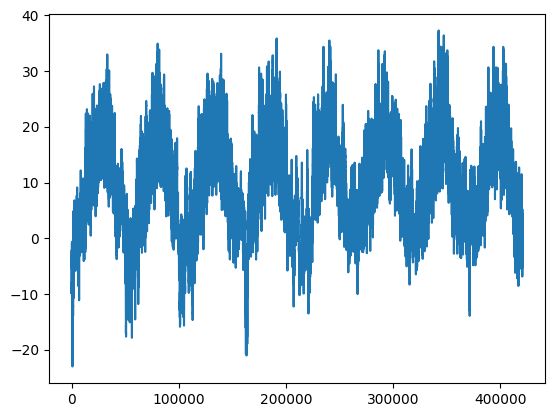

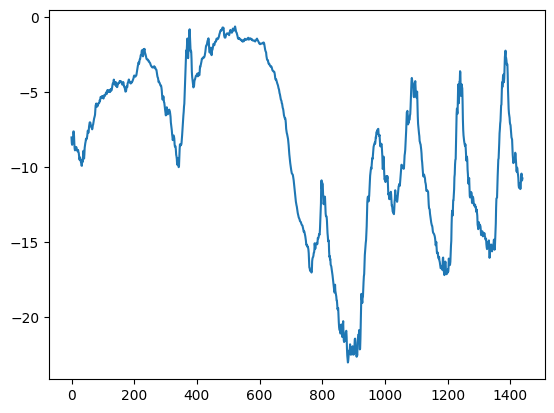

In [3]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

plt.plot(range(1440), temp[:1440])
plt.show()

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


[ 0.90014748 -1.93135845 -1.98211036 -1.86280029  1.07285236 -1.30742164
 -1.47375773 -0.79868641 -1.4762674  -1.47815522  2.12375056 -0.72950452
 -0.78067973 -0.27613603]


In [9]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

In [11]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')

val_steps = (300000 - 200001 - lookback) // batch_size

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

C:\Users\Lukas\AppData\Local\Temp\ipykernel_10808\3122162468.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)


Epoch 1/20

500/500 [==============================] - 9s 16ms/step - loss: 0.7414 - val_loss: 0.3846
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3567 - val_loss: 0.3211
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2896 - val_loss: 0.2883
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2707 - val_loss: 0.3142
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2617 - val_loss: 0.2926
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2522 - val_loss: 0.2954
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2484 - val_loss: 0.2906
Epoch 8/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2456 - val_loss: 0.2973
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2417 - val_loss: 0.2935
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2385 - val_

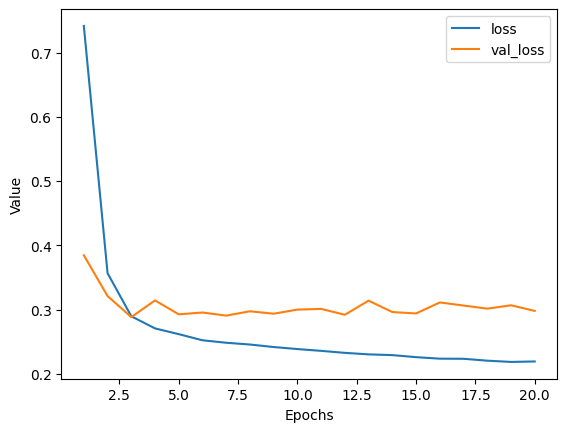

In [14]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()


plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


C:\Users\Lukas\AppData\Local\Temp\ipykernel_10808\3595949272.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)


500/500 [==============================] - 31s 56ms/step - loss: 0.3410 - val_loss: 0.2970
Epoch 2/20
500/500 [==============================] - 27s 54ms/step - loss: 0.3098 - val_loss: 0.2906
Epoch 3/20
500/500 [==============================] - 29s 57ms/step - loss: 0.2967 - val_loss: 0.2954
Epoch 4/20
499/500 [============================>.] - ETA: 0s - loss: 0.2850

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()


plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()